In [1]:
# librerías
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

In [2]:
dir = '/home/user/Desktop/Datos/'
#dir = '/Users/antoniomendez/Desktop/Tesis/Datos/datos_limpios/'

In [3]:
def count_trips_mibici(data_user, threshold = 5, complement = False):
    viajes_user = data_user.groupby([data_user[['Origen_Id', 'Destino_Id']].min(axis=1), data_user[['Origen_Id', 'Destino_Id']].max(axis=1)]).size().reset_index(name='counts')
    viajes_user.columns = ['Est_A', 'Est_B', 'counts']
    if not complement:
        viajes_user = viajes_user[viajes_user['counts'] >= threshold]
    else:
        viajes_user = viajes_user[viajes_user['counts'] < threshold]
    if viajes_user.empty:
        return None
    total = viajes_user['counts'].sum()
    viajes_user['prob'] = viajes_user['counts']/total
    return viajes_user

def leer_matriz(nombre_archivo):
    matriz = []
    with open(nombre_archivo, 'r') as archivo:
        archivo.readline()
        archivo.readline()
        for linea in archivo:
            fila = [float(valor) for valor in linea.strip().split()]
            matriz.append(fila)
    return matriz

def encontrar_estacion(est, matriz):
    for i in range(len(matriz)):
        if matriz[i][0] == est:
            return matriz[i][1], matriz[i][2]
    return None, None

In [4]:
# Load data
data_2019 = pd.read_csv(f'{dir}mibici/2019.csv')
data = data_2019[data_2019['Inicio_del_viaje'].str.startswith('2019-01')]
del data_2019
estaciones = leer_matriz(f'{dir}/Adj_mibici/matrices_estaciones/est_2019.txt')
#estaciones = leer_matriz('/Users/antoniomendez/Desktop/Tesis/Datos/Adj_mibici/matrices_estaciones/est_2019.txt')

In [5]:
users_counts = data['Usuario_Id'].value_counts()
users = users_counts.index.tolist()

In [6]:
def plot_user(counter_user, est, user, save = False, dir = None):
    vertex = list(set(counter_user['Est_A'].unique().tolist() + counter_user['Est_B'].unique().tolist()))
    #print(vertex)
    plt.figure(figsize=(10, 6))
    for i in vertex:
        esta = encontrar_estacion(i, est)
        #print(esta)
        plt.scatter(esta[1], esta[0], color='blue')
        plt.text(esta[1] + 0.00001, esta[0] + 0.00001, str(i), fontsize=7, ha='left', va='bottom')
    for i in range(len(counter_user)):
        current_trip = counter_user.iloc[i]
        estA = current_trip["Est_A"]
        estB = current_trip["Est_B"]
        if estA == estB:
            plt.scatter(encontrar_estacion(estA, est)[1], encontrar_estacion(estA, est)[0], color='red', marker='*', s=100)
        else:
            aux = np.array([encontrar_estacion(estA, est), encontrar_estacion(estB, est)])
            plt.plot(aux[:,1], aux[:,0], color='black', alpha=0.1)
    plt.grid()
    plt.title(f'Usuario {user}')
    if save:
        directory = f'{dir}/'
        if not os.path.exists(directory):
            os.makedirs(directory)
        plt.savefig(f'{directory}/user_{user}.png')
        plt.close()
    else:
        plt.show()

In [7]:
def compute_entropy_normalized(counter_user):
    '''
    args:
    counter_user: DataFrame with columns Est_A, Est_B, counts, prob given by count_trips_mibici by a specific user
    total_counter: DataFrame with columns Est_A, Est_B, counts, prob given by count_trips_mibici by all users
    return:
    entropy: float with the entropy
    '''
    entropy = 0
    N = len(counter_user)
    if N == 0:
        return None
    else:
        for i in range(N):
            prob = counter_user.iloc[i]['prob']
            entropy -= prob * np.log(prob)
        if N > 1:
            entropy /= np.log(N)
        return entropy

In [9]:
entropies = []
users_to_analize = []
for user in users:
    data_user = data[data['Usuario_Id'] == user]
    counter_user = count_trips_mibici(data_user)
    if counter_user is None:
        continue
    entropy = compute_entropy_normalized(counter_user)
    if entropy is not None:
        entropies.append(entropy)
        users_to_analize.append(user)

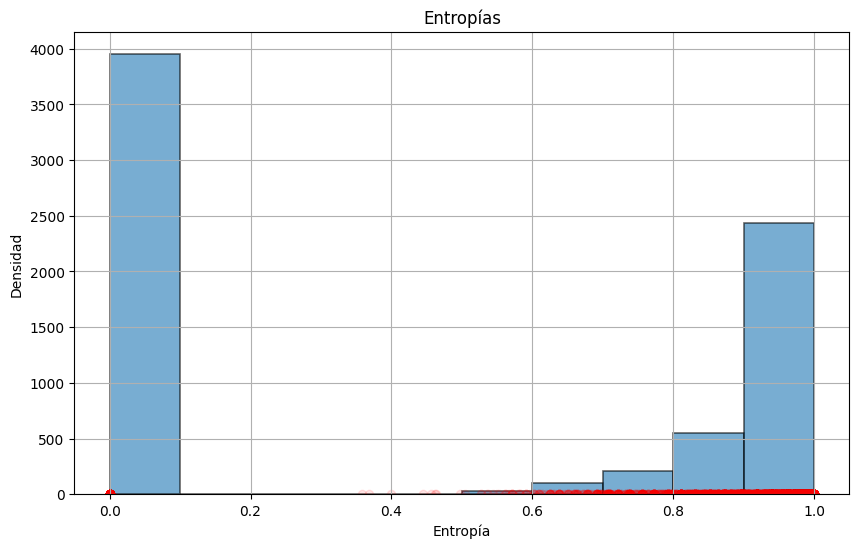

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(entropies, bins=10, alpha=0.6, edgecolor='black', linewidth=1.2)
plt.scatter(entropies, np.zeros(len(entropies)), color='red', alpha=0.1)
plt.xlabel('Entropía')
plt.ylabel('Densidad')
plt.title('Entropías')
plt.grid()
plt.show()

In [28]:
users_0 = []
users_1 = []

for i in range(len(entropies)):
    if entropies[i] == 0:
        users_0.append(users_to_analize[i])
    else:
        users_1.append(users_to_analize[i])

In [29]:
print(f'Usuarios con entropía 0: {len(users_0)}')
print(f'Usuarios con entropía > 0: {len(users_1)}')

Usuarios con entropía 0: 3951
Usuarios con entropía > 0: 3328


In [63]:
edges_0 = []
travels_0 = []

for user in users_0:
    c = count_trips_mibici(data[data['Usuario_Id'] == user])
    if c is not None:
        edges_0.append(len(c))
        travels_0.append(c['counts'].sum())

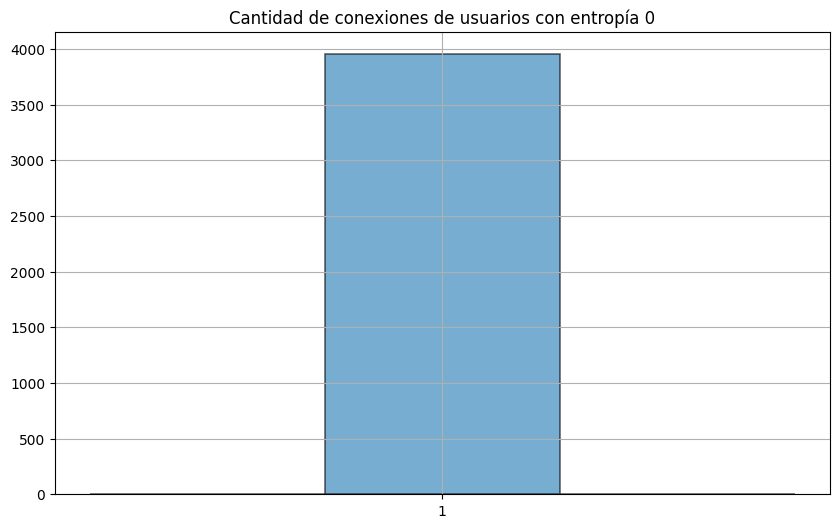

In [47]:
plt.figure(figsize=(10, 6))
plt.hist(edges_0, bins=3, alpha=0.6, edgecolor='black', linewidth=1.2)
plt.title('Cantidad de conexiones de usuarios con entropía 0')
plt.xticks(np.arange(min(edges_0), max(edges_0) + 1, 1))
plt.grid()
plt.show()

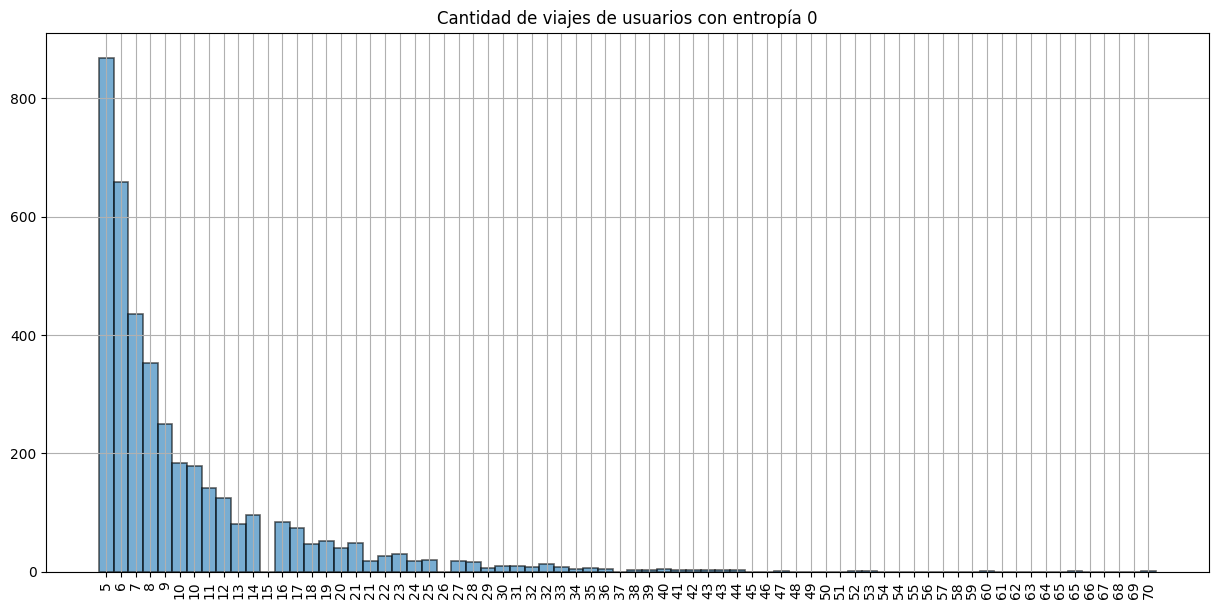

In [ ]:
plt.figure(figsize=(15, 7))
counts, bins, patches = plt.hist(travels_0, bins=72, alpha=0.6, edgecolor='black', linewidth=1.2)
plt.title('Cantidad de viajes de usuarios con entropía 0')

# Calcular los puntos medios de cada bin para alinear correctamente los xticks
bin_centers = 0.5 * (bins[1:] + bins[:-1])
plt.xticks(bin_centers, [f'{int(center)}' for center in bin_centers], rotation=90)

plt.grid()  
plt.show()

In [73]:
edges_1 = []
mean_edges_1 = []
for user in users_1:
    c = count_trips_mibici(data[data['Usuario_Id'] == user])
    edges_1.append(len(c))
    mean_edges_1.append(c['counts'].mean())

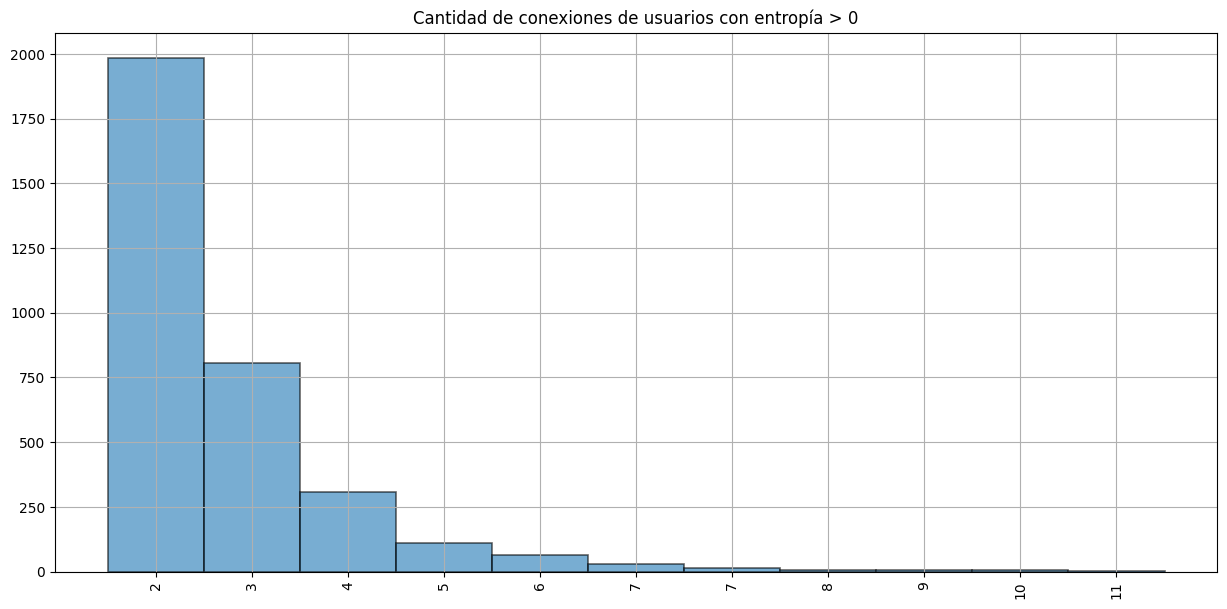

In [93]:
plt.figure(figsize=(15, 7))
counts, bins, patches = plt.hist(edges_1, bins=11, alpha=0.6, edgecolor='black', linewidth=1.2)
plt.title('Cantidad de conexiones de usuarios con entropía > 0')

# Calcular los puntos medios de cada bin para alinear correctamente los xticks
bin_centers = 0.5 * (bins[1:] + bins[:-1])
plt.xticks(bin_centers, [f'{int(center)}' for center in bin_centers], rotation=90)

plt.grid()  
plt.show()

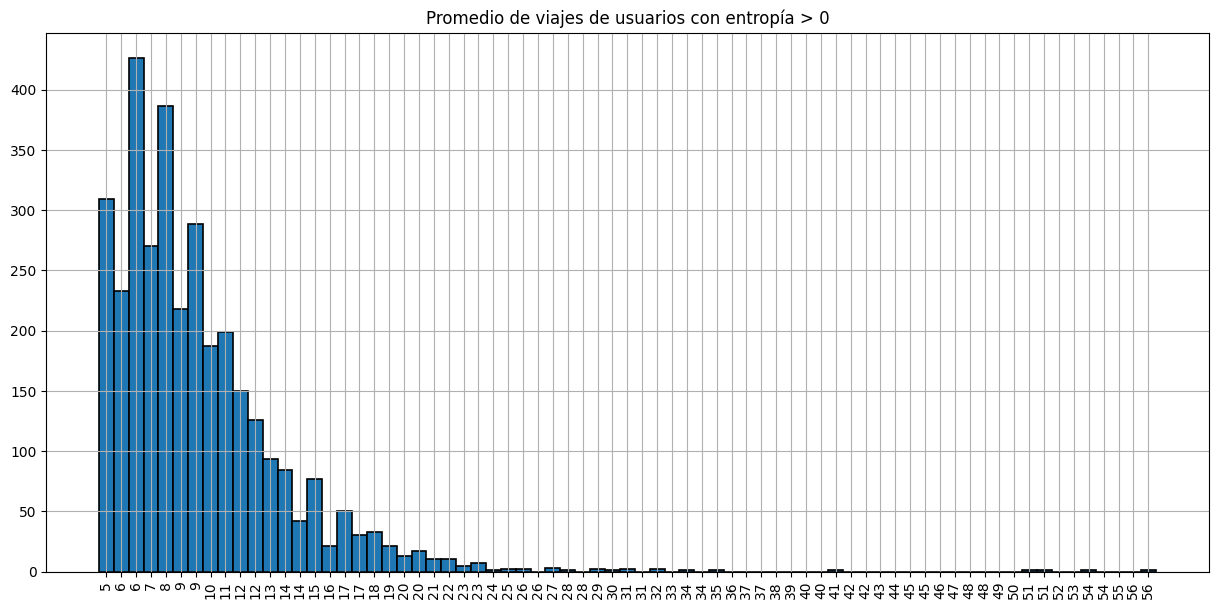

In [170]:
plt.figure(figsize=(15, 7))
counts, bins, patches = plt.hist(mean_edges_1, bins=71, edgecolor='black', linewidth=1.2)
plt.title('Promedio de viajes de usuarios con entropía > 0')

# Calcular los puntos medios de cada bin para alinear correctamente los xticks
bin_centers = 0.5 * (bins[1:] + bins[:-1])
plt.xticks(bin_centers, [f'{int(center)}' for center in bin_centers], rotation=90)

plt.grid()  
plt.show()

In [107]:
info_users = {user: count_trips_mibici(data[data['Usuario_Id'] == user]) for user in users_to_analize}

In [94]:
users_to_analize[:10]

[106406, 113022, 253531, 253520, 143721, 51332, 123665, 341446, 440165, 275435]

In [95]:
entropies[:10]

[0.7103346248704838,
 0.9669436970887703,
 0.7254692388684082,
 0.8204187785404774,
 0.8968788582116444,
 0.8186990073385446,
 0.9022201961539985,
 0.9417760057336677,
 0.8982106048312193,
 0.0]

In [120]:
def guardar_diccionario_count_user_en_txt(diccionario, directorio):
    """
    Guarda un diccionario de DataFrames en archivos .csv y crea un archivo de índice en el directorio dado.

    Args:
        diccionario (dict): El diccionario con DataFrames como valores.
        directorio (str): El directorio donde se guardarán los archivos CSV y el archivo de índice.
    """
    # Nos aseguramos de que el directorio exista
    os.makedirs(directorio, exist_ok=True)
    ruta_indice = os.path.join(directorio, "indice.txt")

    # Abrimos el archivo índice para escribir
    with open(ruta_indice, "w") as archivo_indice:
        for clave, dataframe in diccionario.items():
            # Guardamos cada DataFrame en un archivo CSV
            nombre_csv = f"{clave}.csv"
            ruta_csv = os.path.join(directorio, nombre_csv)
            dataframe.to_csv(ruta_csv, index=False)
            
            # Escribimos la clave y el nombre del archivo en el índice
            archivo_indice.write(f"{clave}:{nombre_csv}\n")

In [ ]:
guardar_diccionario_count_user_en_txt(info_users, f'{dir}mibici/pruebas_2019/')

In [10]:
def cargar_diccionario_count_user_desde_txt(directorio):
    """
    Carga un diccionario de DataFrames a partir de archivos CSV usando un archivo de índice en el directorio dado.

    Args:
        directorio (str): El directorio donde se encuentran los archivos CSV y el archivo de índice.

    Returns:
        dict: El diccionario reconstruido con claves y DataFrames.
    """
    diccionario = {}
    ruta_indice = os.path.join(directorio, "indice.txt")

    # Leemos el archivo índice
    with open(ruta_indice, "r") as archivo_indice:
        for linea in archivo_indice:
            clave, nombre_csv = linea.strip().split(":")
            ruta_csv = os.path.join(directorio, nombre_csv)
            
            # Cargamos cada CSV en un DataFrame y lo añadimos al diccionario
            diccionario[int(clave)] = pd.read_csv(ruta_csv)
    
    return diccionario

In [11]:
info_users = cargar_diccionario_count_user_desde_txt(f'{dir}mibici/pruebas_2019/')

In [121]:
info_users[users_to_analize[0]]

,Est_A,Est_B,counts,prob
0,4,86,6,0.017442
1,70,70,21,0.061047
2,70,71,12,0.034884
3,70,86,106,0.308140
4,71,86,28,0.081395
5,86,86,171,0.497093


A ver qué encuentro en los datos con entropia mayor a cero.

In [133]:
min_entropy_index = np.argmin([e if e > 0 else float('inf') for e in entropies])
min_entropy_index

197

In [137]:
min_entropy_user = users_to_analize[min_entropy_index]
min_entropy_user = info_users[min_entropy_user]
print(entropies[min_entropy_index])
min_entropy_user

0.3582686386042453


,Est_A,Est_B,counts,prob
0,288,288,96,0.932039
1,288,295,7,0.067961


In [138]:
max_entropy_index = np.argmax(entropies)
max_entropy_index

62

In [139]:
max_entropy_user = users_to_analize[max_entropy_index]
max_entropy_user = info_users[max_entropy_user]
print(entropies[max_entropy_index])
max_entropy_user

1.0


,Est_A,Est_B,counts,prob
0,110,266,5,0.5
1,162,266,5,0.5


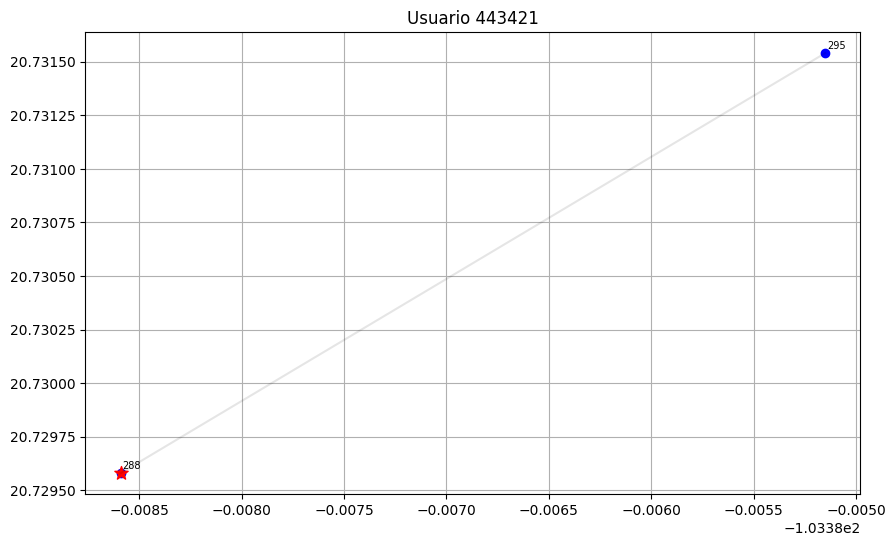

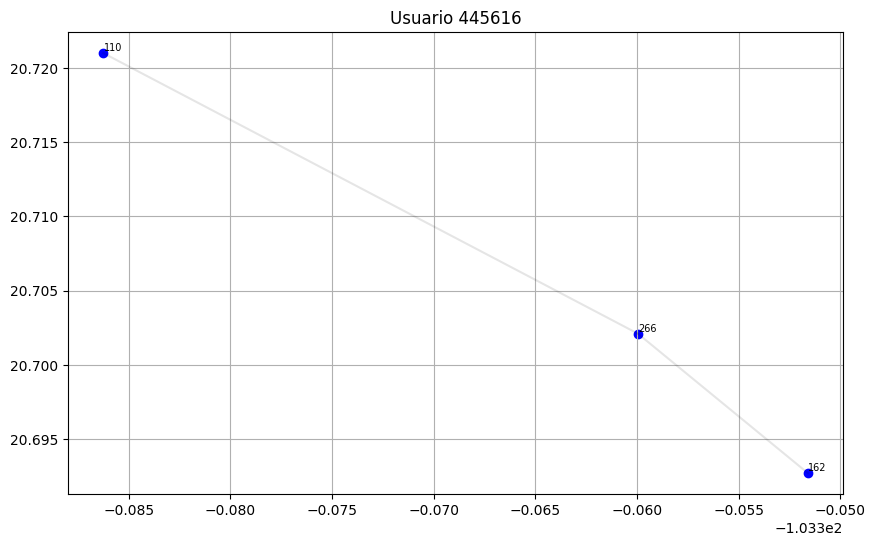

In [184]:
plot_user(min_entropy_user, estaciones, users_to_analize[min_entropy_index])
plot_user(max_entropy_user, estaciones, users_to_analize[max_entropy_index])

In [142]:
users_with_entropy1 = [user for user in users_to_analize if entropies[users_to_analize.index(user)] == 1]
len(users_with_entropy1)

231

In [12]:
info_users_c = {user: count_trips_mibici(data[data['Usuario_Id'] == user], complement=True) for user in users_to_analize}

In [149]:
users_to_analize[0]

106406

In [148]:
info_users_c[users_to_analize[0]]

,Est_A,Est_B,counts,prob
0,3,70,1,0.038462
1,3,71,1,0.038462
2,3,86,4,0.153846
3,4,70,1,0.038462
4,4,71,1,0.038462
9,71,71,3,0.115385
10,71,72,1,0.038462
11,71,84,1,0.038462
13,71,87,1,0.038462
14,72,86,3,0.115385


In [13]:
entropias_c = []
users_c = []

for user in users_to_analize:
    current_user = info_users_c[user]
    if current_user is None:
        entropias_c.append(None)
        continue
    entropy = compute_entropy_normalized(info_users_c[user])
    entropias_c.append(entropy)
    users_c.append(user)

In [14]:
users_to_test = []

for user in users_to_analize:
    index = users_to_analize.index(user)
    if user in users_c and entropies[index] > 0 and entropias_c[index] > 0:
        users_to_test.append(user)

In [15]:
np.save('users_to_test.npy', np.array(users_to_test))

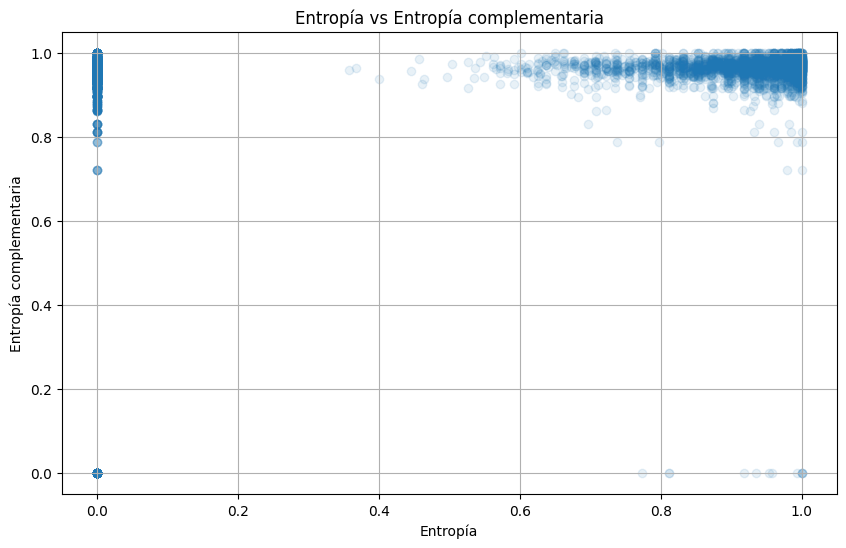

In [157]:
plt.figure(figsize=(10, 6))
plt.scatter(entropies, entropias_c, alpha=0.1)
plt.xlabel('Entropía')
plt.ylabel('Entropía complementaria')
plt.title('Entropía vs Entropía complementaria')
plt.grid()
plt.show()

In [160]:
info_users[users_to_analize[0]], info_users_c[users_to_analize[0]], entropies[0], entropias_c[0]

(   Est_A  Est_B  counts      prob
 0      4     86       6  0.017442
 1     70     70      21  0.061047
 2     70     71      12  0.034884
 3     70     86     106  0.308140
 4     71     86      28  0.081395
 5     86     86     171  0.497093,
     Est_A  Est_B  counts      prob
 0       3     70       1  0.038462
 1       3     71       1  0.038462
 2       3     86       4  0.153846
 3       4     70       1  0.038462
 4       4     71       1  0.038462
 9      71     71       3  0.115385
 10     71     72       1  0.038462
 11     71     84       1  0.038462
 13     71     87       1  0.038462
 14     72     86       3  0.115385
 15     84     86       1  0.038462
 16     85     86       3  0.115385
 18     86     87       2  0.076923
 19     86    277       2  0.076923
 20     86    283       1  0.038462,
 0.7103346248704838,
 0.9445517607061652)

In [172]:
users_to_explore = []
entropies_c_explore = []
for i in range(len(users_to_analize)):
    if entropies[i] == 0 and entropias_c[i] != None:
        if entropias_c[i] >= 0.6:
            users_to_explore.append(users_to_analize[i])
            entropies_c_explore.append(entropias_c[i])

In [168]:
len(users_to_explore), len(users_to_analize)

(3802, 7279)

In [169]:
users_to_explore[:10]

[275435, 10654, 420420, 445621, 365057, 120126, 310005, 61706, 454344, 214514]

In [174]:
entropies_c_explore[:10]

[0.9873676047790217,
 0.9764963652947184,
 0.9829718195948786,
 0.9805550379383056,
 0.9835343564755962,
 0.978227768557938,
 0.9716485624962731,
 0.9699770219722883,
 0.9861072613497114,
 0.9780936582817329]

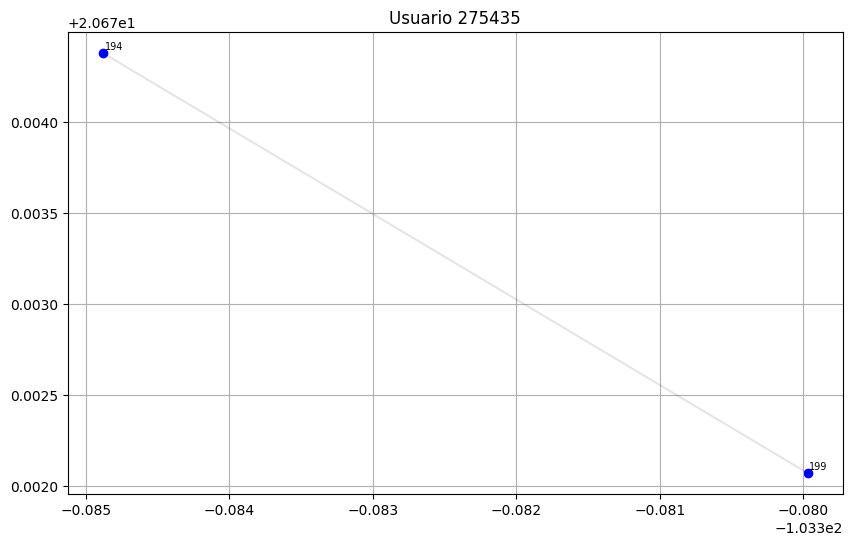

In [185]:
plot_user(info_users[users_to_explore[0]], estaciones, users_to_explore[0])

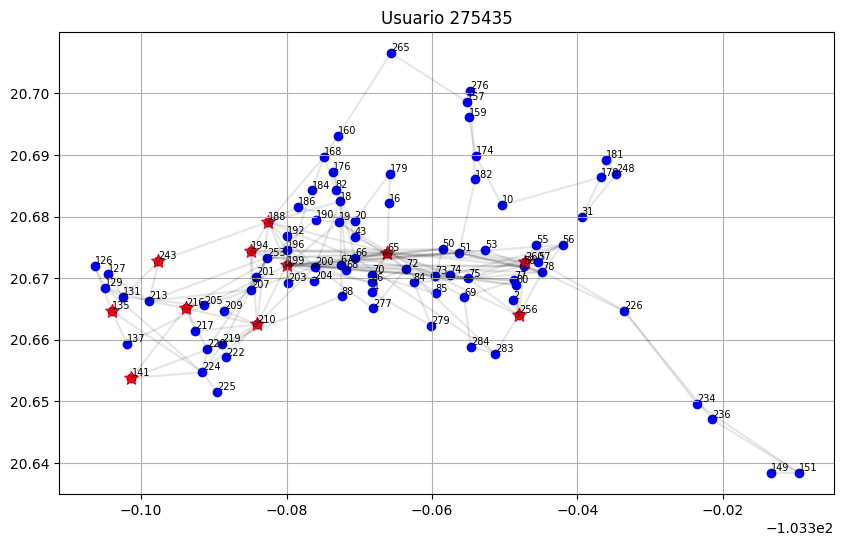

In [186]:
plot_user(info_users_c[users_to_explore[0]], estaciones, users_to_explore[0])

In [187]:
users_to_explore = np.array(users_to_explore)
np.save('usuarios.npy', users_to_explore)

In [188]:
usuarios_prueba = np.load('usuarios.npy')

In [189]:
usuarios_prueba[:10]

array([275435,  10654, 420420, 445621, 365057, 120126, 310005,  61706,
       454344, 214514])